In [1]:
import json
from pathlib import Path    
import os
import itertools
import pandas as pd
import numpy as np
import json


def print_coverage():
    def get_progress() -> set:
        progress_path = Path(os.path.abspath('')).resolve() / "output" / f"results-merged.json"
        assert progress_path.exists()
        progress: dict = json.loads(progress_path.read_text())
        progress = [r["args"] for r in progress["results"]]  # type: ignore
        progress = [list(r.values()) for r in progress]  # type: ignore
        progress = [[True if e == "True" else False if e == "False" else e for e in r] for r in progress]  # type: ignore
        progress = [[None if e == "None" else e for e in r] for r in progress]  # type: ignore
        progress = [tuple(r) for r in progress]  # type: ignore
        return set(progress)

    COMBINATIONS = {
        "dataset": ["congress", "mushroom", "reviews", "seattle"],
        "scaling": ["mean", "minmax", None],
        "labeling": [True, False],
        "imputing": [True, False],
        "classifier_type": ["mlp", "knn", "rf"],
        "cross_val": [True, False],
    }
    all_combinations = list(itertools.product(*COMBINATIONS.values()))
    print(f"{len(all_combinations)} total")
    remaining_combinations = set(all_combinations) - get_progress()
    print(f"{len(remaining_combinations)} remaining")
    covered_percentage = 100 - len(remaining_combinations) / len(all_combinations) * 100
    print(f"{covered_percentage:.2f}% coverage of search space")


print_coverage()


# read as df
json_path = Path(os.path.abspath('')).resolve() / "output" / f"results-merged.json"
assert json_path.exists()
results: dict = json.loads(json_path.read_text())
results = results["results"]
assert isinstance(results, list)
df = pd.DataFrame(results)


# regex to find errors in json that break the parsing:
# "args":[\s\n\t]*\{[\s\n\t]*"dataset":[\s\n\t]*"mushroom",[\s\n\t]*"scaling":[\s\n\t]*"minmax",[\s\n\t]*"labeling":[\s\n\t]*"True",[\s\n\t]*"imputing":[\s\n\t]*"True",[\s\n\t]*"classifier_type":[\s\n\t]*"knn",[\s\n\t]*"cross_val":[\s\n\t]*"True"[\s\n\t]*\},


# restructure
df["dataset"] = df["args"].apply(lambda x: x["dataset"])
df["scaling"] = df["args"].apply(lambda x: x["scaling"])
df["labeling"] = df["args"].apply(lambda x: x["labeling"])
df["imputing"] = df["args"].apply(lambda x: x["imputing"])
df["classifier_type"] = df["args"].apply(lambda x: x["classifier_type"])
df["cross_val"] = df["args"].apply(lambda x: x["cross_val"])
df.drop(columns=["args"], inplace=True)

df.drop(columns=["validation"], inplace=True)
df.drop(columns=["classifier_config"], inplace=True)

# check if metrics are present
metric_cols = ["time", "accuracy_score", "balanced_accuracy_score", "precision_score", "recall_score", "zero-one-loss"]
for m in metric_cols:
    assert all(df[m].notnull())
    assert all(df[m].apply(lambda x: isinstance(x, float)))

df

288 total
9 remaining
96.88% coverage of search space


,time,accuracy_score,balanced_accuracy_score,precision_score,recall_score,zero-one-loss,dataset,scaling,labeling,imputing,classifier_type,cross_val
0,1.764361,0.014667,-0.008593,0.015000,0.289474,0.985333,reviews,minmax,True,False,rf,True
1,34.080433,0.999673,0.999296,0.999673,0.999673,0.000327,mushroom,minmax,False,True,knn,False
2,0.036873,0.954545,0.913043,0.958498,0.954545,0.045455,congress,minmax,False,True,rf,False
3,1916.467637,0.505333,0.482297,0.507370,0.505333,0.494667,reviews,None,False,True,mlp,True
4,223.978987,0.785357,0.121598,0.816854,0.985347,0.214643,seattle,minmax,True,True,mlp,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1131,3700.952599,0.814263,0.197388,0.822816,0.913618,0.185737,seattle,mean,False,True,mlp,False
1132,0.513918,0.743196,0.103019,0.730280,0.813807,0.256804,seattle,mean,True,True,rf,False
1133,3123.625606,0.815109,0.193471,0.806248,0.888010,0.184891,seattle,mean,False,False,mlp,True
1134,6.515439,0.250763,0.000000,0.250763,1.000000,0.749237,seattle,mean,True,True,rf,True


/var/folders/bh/4ympj4l52bs8wxpg114kdh1m0000gn/T/ipykernel_75055/3921080264.py:8: FutureWarning: The provided callable <function mean at 0x103c49620> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = pltdf.pivot_table(


<Axes: title={'center': 'Avg. accuracy per dataset and classifier'}, xlabel='Dataset, Classifier', ylabel='Avg. accuracy'>

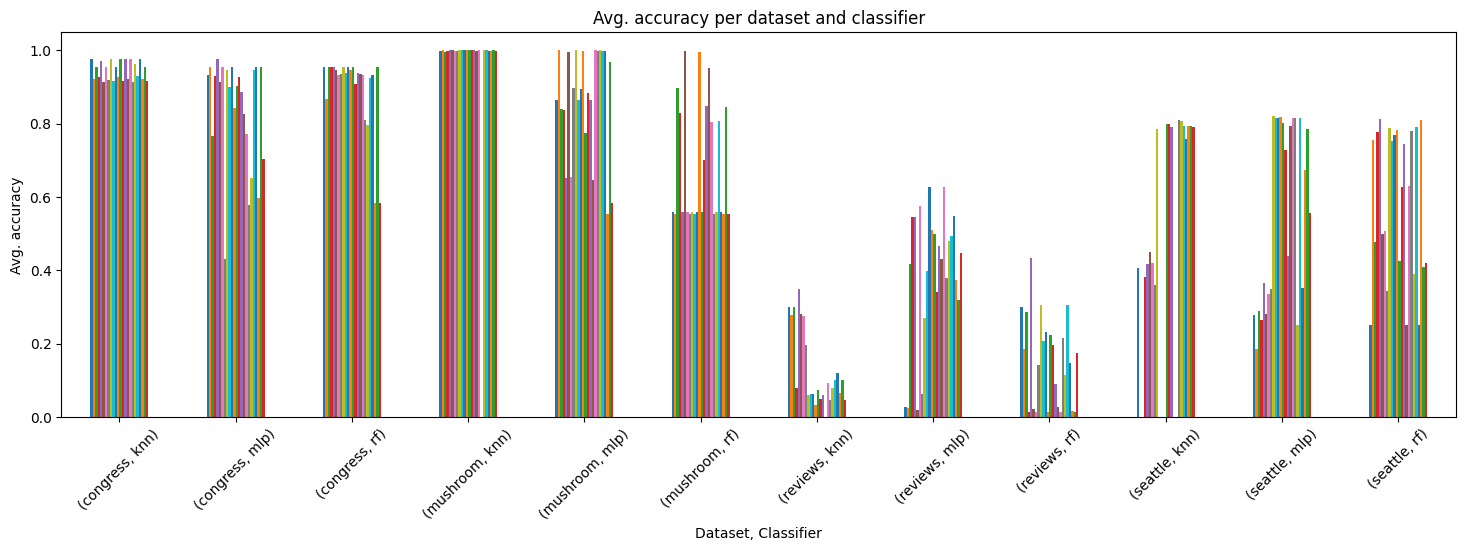

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

pltdf = df.copy()

# pltdf.groupby(["dataset", "classifier_type"])["zero-one-loss"].mean().unstack().plot(kind="bar", figsize=(12, 6))

table = pltdf.pivot_table(
    index=["dataset", "classifier_type"],
    columns=["scaling", "labeling", "imputing", "cross_val"],
    values="accuracy_score",
    aggfunc=np.mean)
table.plot(
    kind="bar",
    figsize=(18, 5),
    legend=False,
    ylabel="Avg. accuracy",
    xlabel="Dataset, Classifier",
    title="Avg. accuracy per dataset and classifier",
    rot=45,
)

metric='time'


/var/folders/bh/4ympj4l52bs8wxpg114kdh1m0000gn/T/ipykernel_75055/159367108.py:12: FutureWarning: The provided callable <function mean at 0x103c49620> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = pltdf.pivot_table(


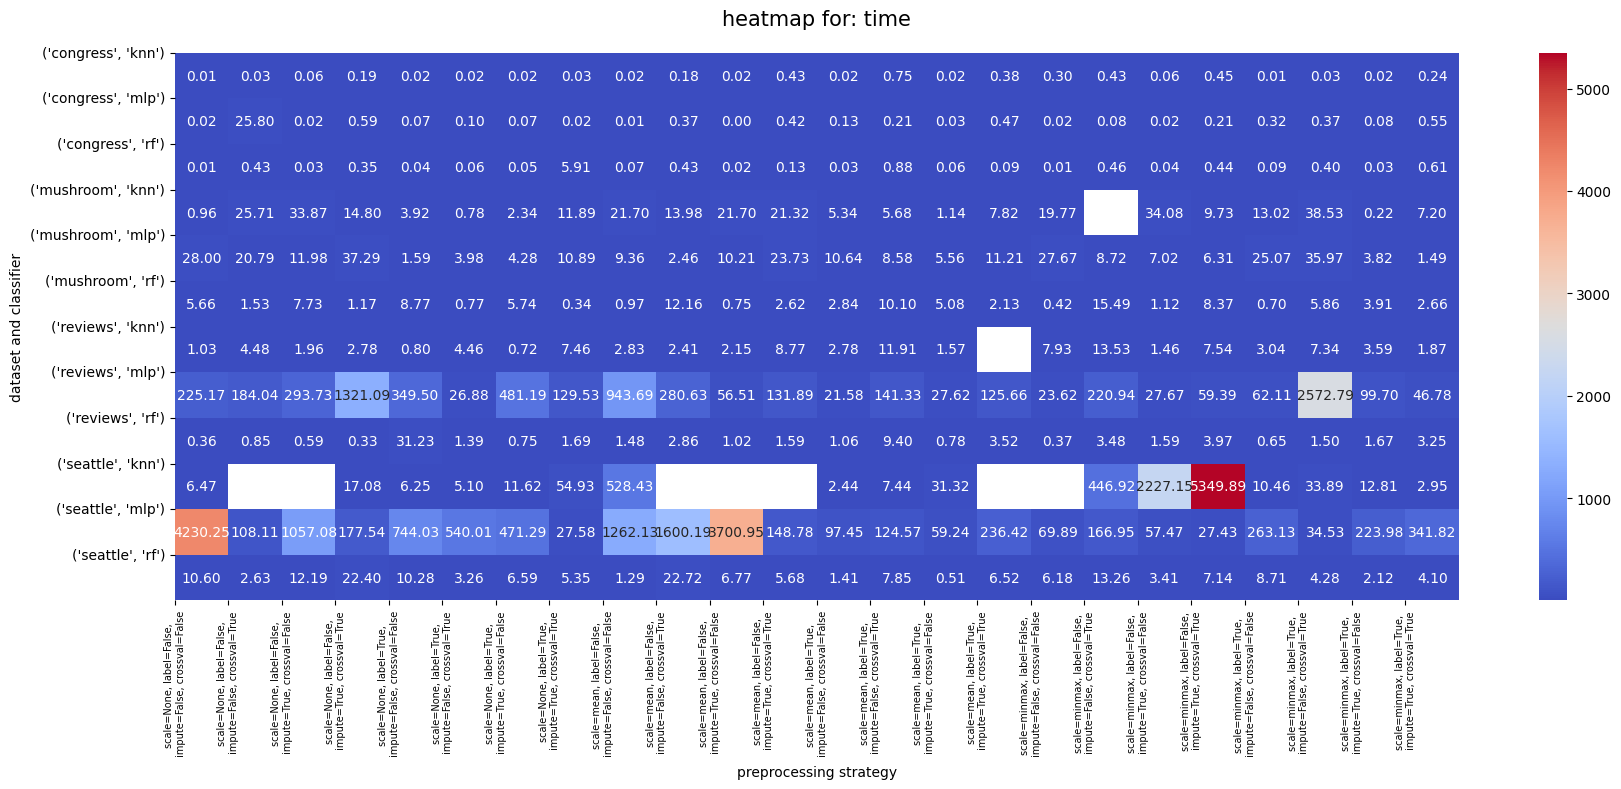

metric='accuracy_score'


/var/folders/bh/4ympj4l52bs8wxpg114kdh1m0000gn/T/ipykernel_75055/159367108.py:12: FutureWarning: The provided callable <function mean at 0x103c49620> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = pltdf.pivot_table(


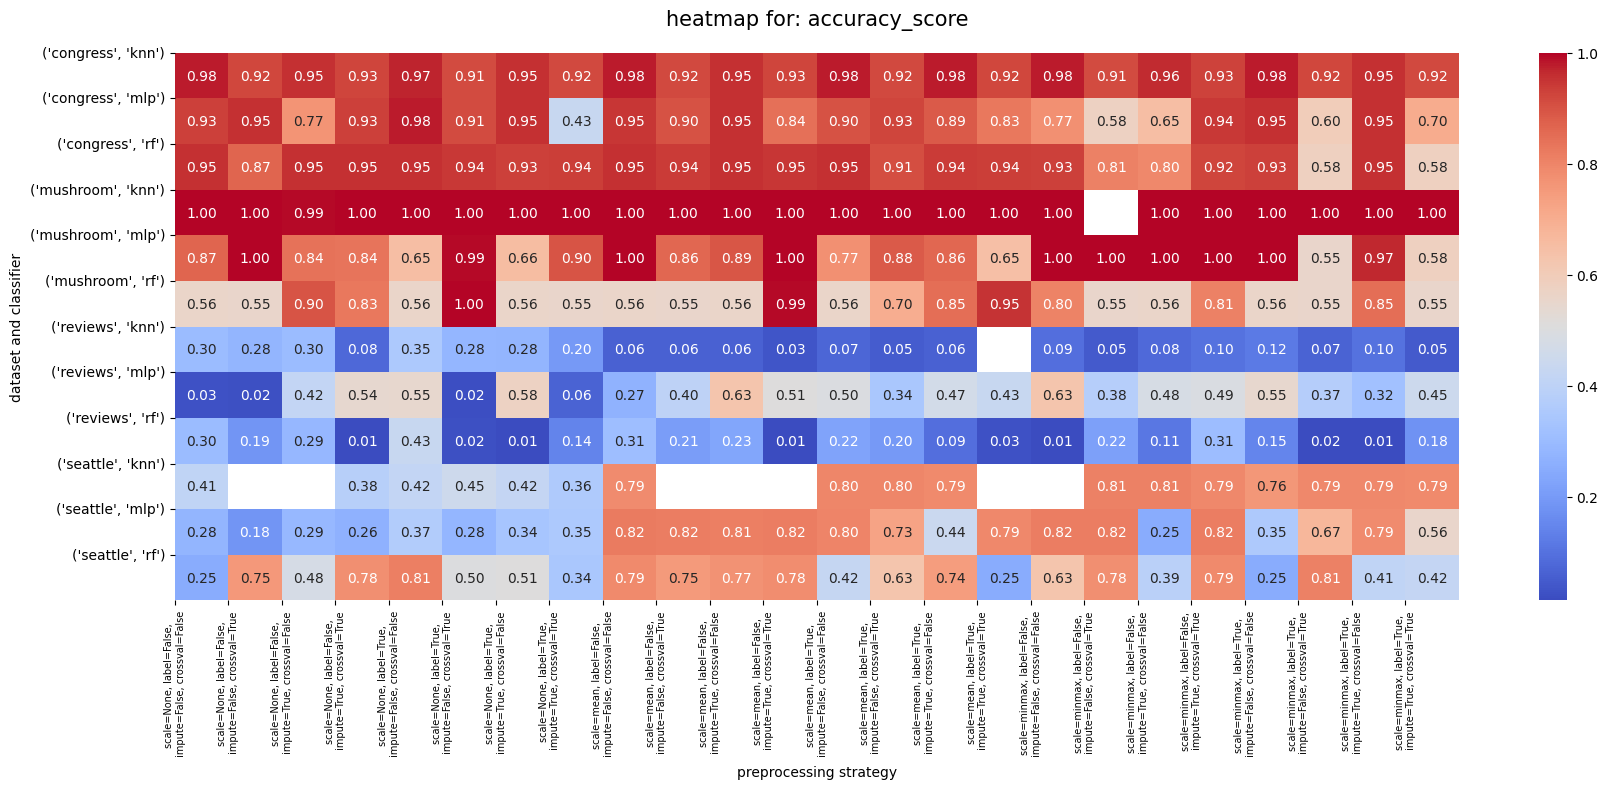

metric='balanced_accuracy_score'


/var/folders/bh/4ympj4l52bs8wxpg114kdh1m0000gn/T/ipykernel_75055/159367108.py:12: FutureWarning: The provided callable <function mean at 0x103c49620> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = pltdf.pivot_table(


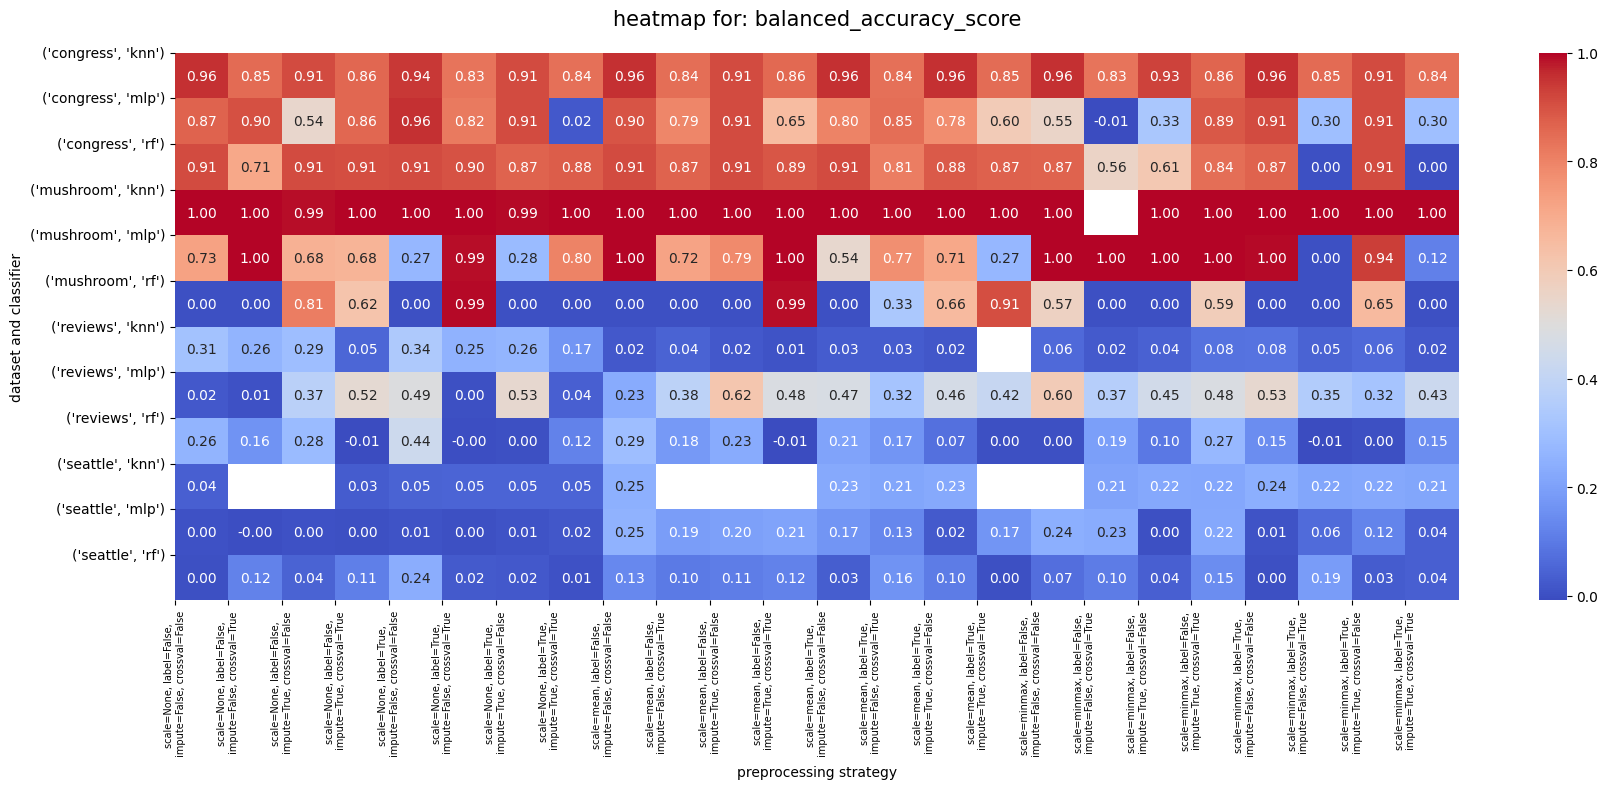

metric='precision_score'


/var/folders/bh/4ympj4l52bs8wxpg114kdh1m0000gn/T/ipykernel_75055/159367108.py:12: FutureWarning: The provided callable <function mean at 0x103c49620> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = pltdf.pivot_table(


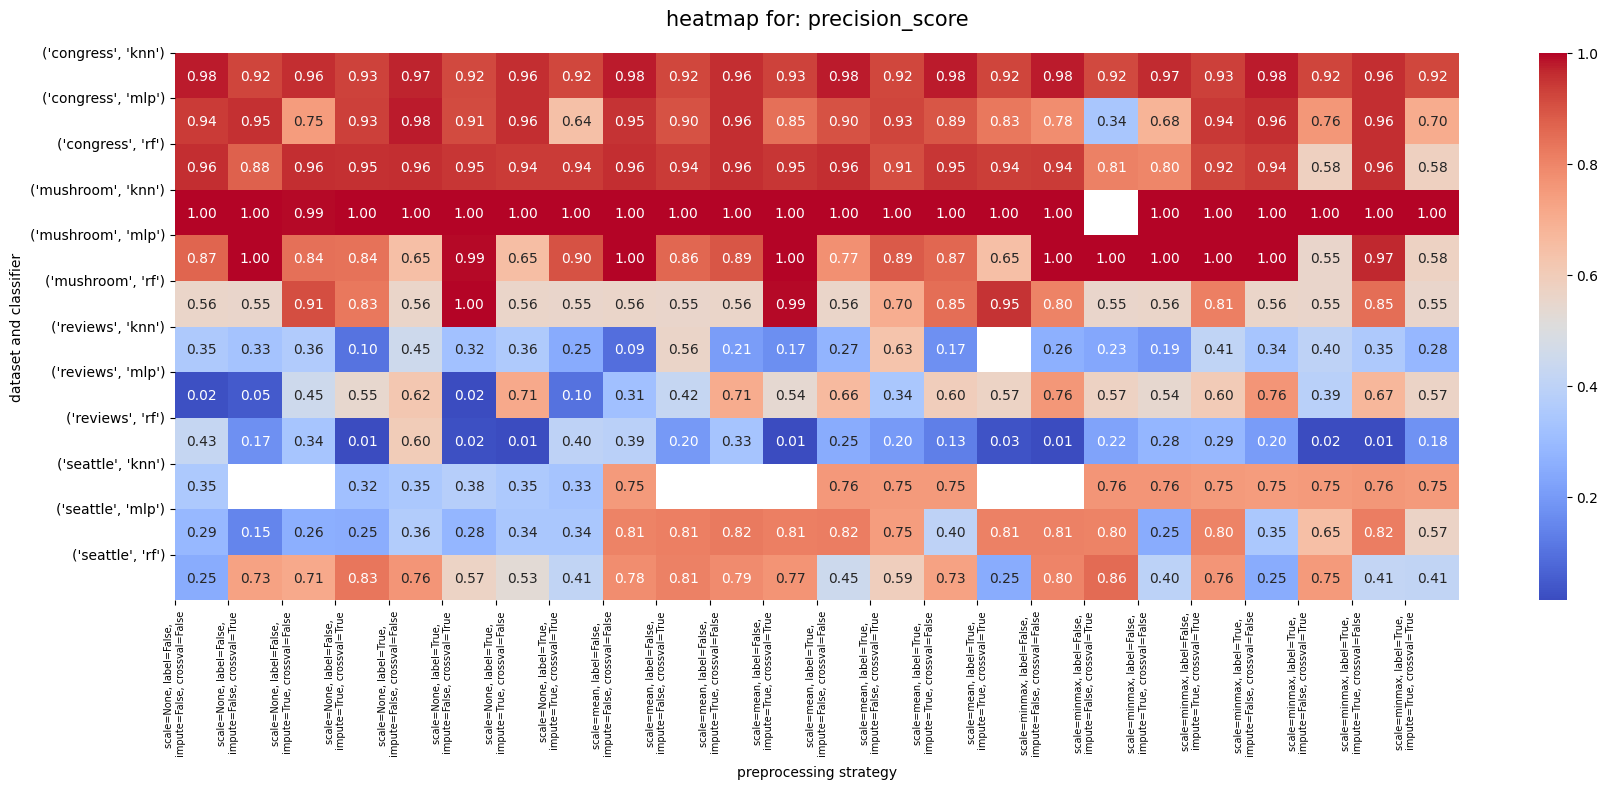

metric='recall_score'


/var/folders/bh/4ympj4l52bs8wxpg114kdh1m0000gn/T/ipykernel_75055/159367108.py:12: FutureWarning: The provided callable <function mean at 0x103c49620> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = pltdf.pivot_table(


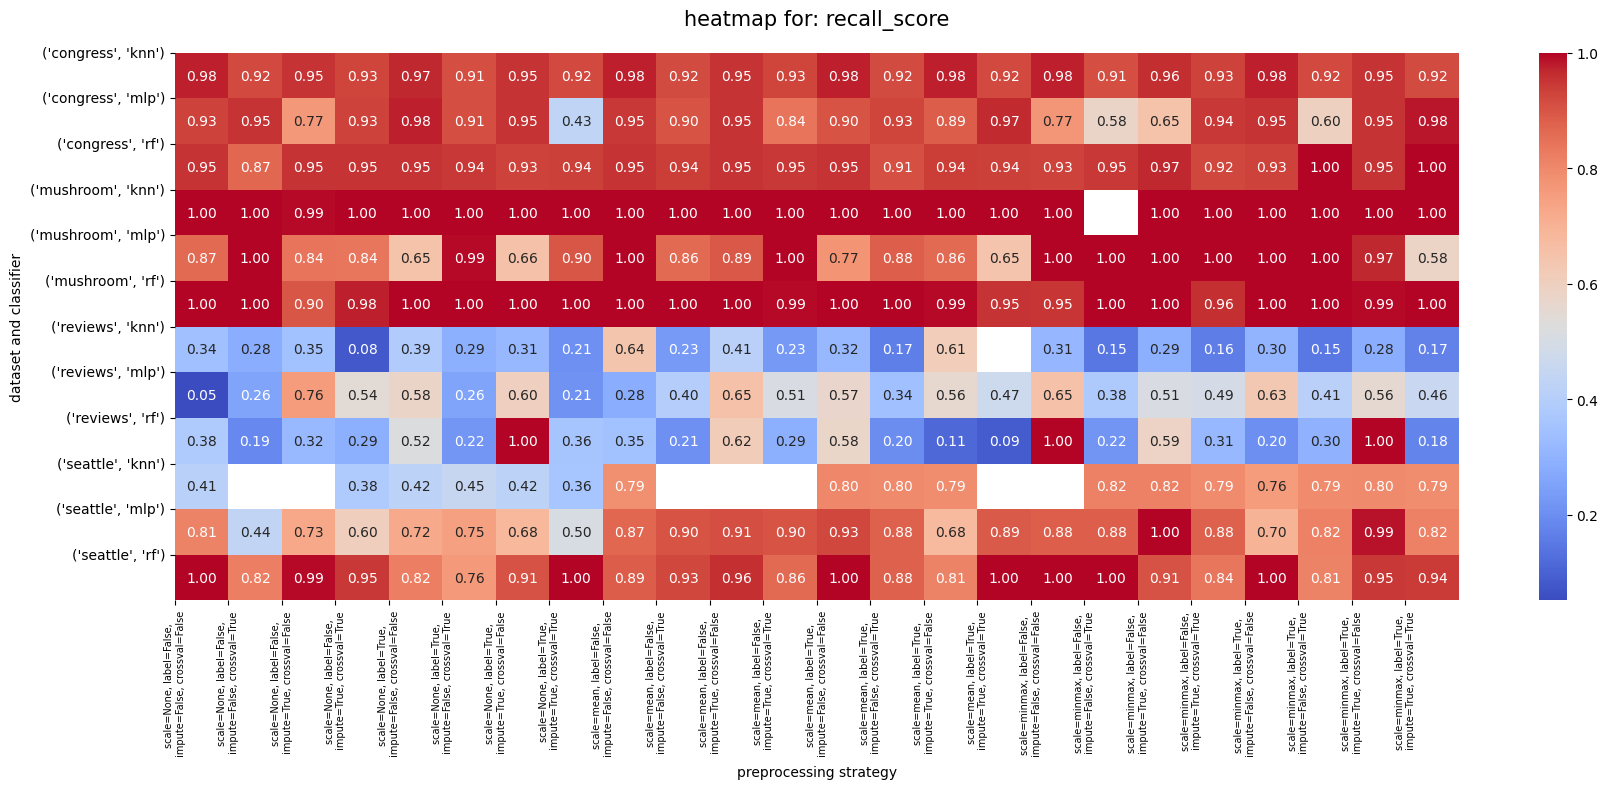

metric='zero-one-loss'


/var/folders/bh/4ympj4l52bs8wxpg114kdh1m0000gn/T/ipykernel_75055/159367108.py:12: FutureWarning: The provided callable <function mean at 0x103c49620> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = pltdf.pivot_table(


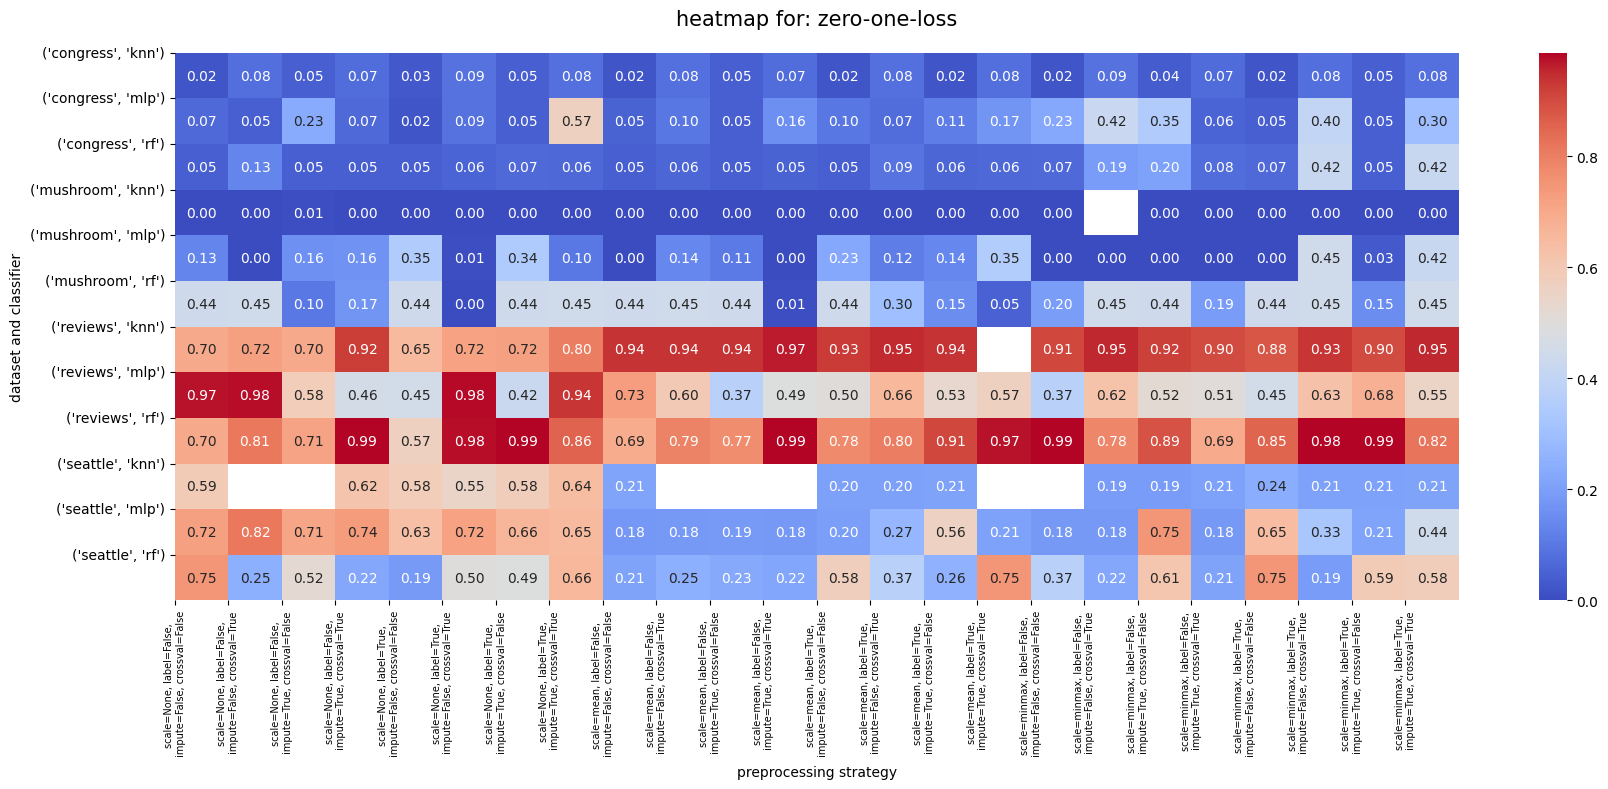

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

save_path = Path(os.path.abspath('')).resolve() / "output" / "viz"

metric_cols = ["time", "accuracy_score", "balanced_accuracy_score", "precision_score", "recall_score", "zero-one-loss"]
for metric in metric_cols:
    print(f"{metric=}")

    pltdf = df.copy()

    table = pltdf.pivot_table(
        values=metric,
        index=["dataset", "classifier_type"],   
        columns=["scaling", "labeling", "imputing", "cross_val"],
        aggfunc=np.mean)

    plt.figure(figsize=(18, 8))
    sns.heatmap(table, annot=True, fmt=".2f", cmap="coolwarm")

    # title
    plt.title(f"heatmap for: {metric}", fontsize=15, pad=20, loc="center")

    # y labels
    plt.yticks(range(len(table.index)), table.index) # type: ignore
    plt.yticks(fontsize=10)
    # add pad for y labels
    plt.ylabel("dataset and classifier")

    # x labels
    labels = table.columns.to_list()
    labels = [f"scale={x[0]}, label={x[1]},\n impute={x[2]}, crossval={x[3]}" for x in labels]
    plt.xticks(range(len(labels)), labels)
    plt.xticks(fontsize=7)
    plt.xlabel("preprocessing strategy")

    # save plot
    plt.tight_layout()
    # plt.savefig(save_path / f"heatmap_{metric}.png")
    plt.show()
    plt.close()
